In [1]:
import gc
from transformers import AutoModelForCausalLM, AutoTokenizer
from sae_lens import SAE  # pip install sae-lens
import torch
from jaxtyping import Float
from torch import Tensor
from typing import List, Tuple, Optional
import tqdm
from transformer_lens.utils import tokenize_and_concatenate
from datasets import load_dataset

def get_sae(model_name: str = "google/gemma-2-2b", layer: int = 20):
    assert model_name in ["gpt2", "google/gemma-2-2b"]
    with torch.no_grad():
        # 1. Fetch the SAE
        assert model_name in ["gpt2", "google/gemma-2-2b"]
        if model_name == "gpt2":
            sae, cfg_dict, sparsity = SAE.from_pretrained(
                    release = "gpt2-small-res-jb",
                    sae_id = f"blocks.{layer}.hook_resid_pre",
                    device = "cuda"
                )
        else:
            sae, cfg_dict, sparsity = SAE.from_pretrained(
                release="gemma-scope-2b-pt-res-canonical",
                sae_id=f"layer_{layer}/width_16k/canonical",
            )
        sae.cuda()
        sae.eval()
        for p in sae.parameters():
            p.requires_grad = False
            p.grad = None
        return sae
def get_model(model_name: str = "google/gemma-2-2b"):
    model = AutoModelForCausalLM.from_pretrained(model_name, device_map="cuda")
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
        p.grad = None
    return model
    
def get_tokenizer(model_name: str = "google/gemma-2-2b"):
    return AutoTokenizer.from_pretrained(model_name)

def get_dataset(dataset_name: str = "stas/openwebtext-10k", batch_size: Optional[int] = None, tokenizer: Optional[AutoTokenizer] = None):
    if tokenizer is None:
        raise ValueError("Tokenizer is required for `get_dataset`")
    dataset_name = "stas/openwebtext-10k"  # yolo
    dataset = load_dataset(
        dataset_name, split="train", trust_remote_code=True
    )  # Smaller version
    tokens = tokenize_and_concatenate(
        dataset=dataset,  # type: ignore
        tokenizer=tokenizer,  # type: ignore
        streaming=True,
        # NOTE: all these have context 128
        max_length=128,  # sae.cfg.context_size,
        add_bos_token=True,  # sae.cfg.prepend_bos,
    )["tokens"]
    tokens = tokens.to("cuda")  # eh
    if batch_size is not None:
        tokens = tokens[:batch_size]
    return tokens

def get_activations(model_name: str = "google/gemma-2-2b", layer: int = 20, return_raw: bool = False):
    torch.set_grad_enabled(False)
    with torch.no_grad():
        """
        Load the things...
        """
        # 1. Get our model tokenizer etc...
        # sae = get_sae(model_name, layer) # Not used yet lmao
        model = get_model(model_name)
        tokenizer = get_tokenizer(model_name)

        # GEt the full dataset
        dataset_name = "stas/openwebtext-10k"  # yolo
        n_batch = 10_000
        tokens = get_dataset(dataset_name, batch_size=n_batch, tokenizer=tokenizer)

    """
    Collect some output activations.
    """
    collected_outputs = []
    def gather_target_act_hook(mod, inputs, outputs):
        nonlocal collected_outputs
        assert isinstance(outputs, tuple)
        assert isinstance(outputs[0], torch.Tensor), f"Expected a single tensor output, got {outputs}" # fmt: skip
        collected_outputs.append(outputs[0].detach().requires_grad_(False).cpu())
        return outputs


    if model_name == "gpt2":
        handle = model.transformer.h[layer].register_forward_hook(gather_target_act_hook)
    else:
        handle = model.model.layers[layer].register_forward_hook(gather_target_act_hook)
    try:
        batch_size = 100
        for i in tqdm.trange(0, tokens.shape[0], batch_size):
            j = min(i + batch_size, tokens.shape[0])
            model.forward(tokens[i:j])
    finally:
        handle.remove()
    collected_outputs = torch.cat(collected_outputs, dim=0)
    print(collected_outputs.shape)

    tokens_is_special = (
        (tokens == tokenizer.bos_token_id)
        | (tokens == tokenizer.eos_token_id)
        | (tokens == tokenizer.pad_token_id)
    )
    if return_raw:
        assert tokens.shape == collected_outputs.shape[:-1], f"tokens.shape: {tokens.shape}, collected_outputs.shape: {collected_outputs.shape}"
        assert collected_outputs.shape[:-1] == tokens_is_special.shape, f"collected_outputs.shape: {collected_outputs.shape}, tokens_is_special.shape: {tokens_is_special.shape}"
        return collected_outputs, tokens_is_special, tokens
    tokens_is_special_flat = tokens_is_special.cpu().flatten()
    collected_outputs_flat = collected_outputs.cpu().reshape(
        -1, collected_outputs.shape[-1]
    )
    activations = collected_outputs_flat[~tokens_is_special_flat, :]
    print(activations.shape)  # These are the ones we will use to understand our SAE
    return activations

/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import torch
from torch import Tensor
from typing import Callable, Optional

class QuadraticFeatureMap:
    """Second‑order (quadratic) feature expansion.

    Given activations X ∈ ℝ^{N×d}, returns Φ(X) that concatenates an optional bias,
    the original linear terms, and the unique quadratic terms x_i x_j with i ≤ j.
    Optionally subsamples quadratic terms to keep dimensionality manageable.

    By o3.
    """

    def __init__(
        self,
        include_bias: bool = True,
        include_linear: bool = True,
        max_quadratic_features: Optional[int] = None,
    ) -> None:
        self.include_bias = include_bias
        self.include_linear = include_linear
        self.max_quadratic_features = max_quadratic_features
        self._tri_idx_cache = {}

    def _upper_tri_indices(self, d: int, device: torch.device):
        # Cache indices so we don't re‑allocate on every call
        if (d, device) not in self._tri_idx_cache:
            self._tri_idx_cache[(d, device)] = torch.triu_indices(d, d, device=device)
        return self._tri_idx_cache[(d, device)]

    def __call__(self, x: Tensor) -> Tensor:
        """Compute the quadratic feature map.

        Args:
            x: (N, d) activations.
        Returns:
            Φ(x): (N, D) transformed feature matrix.
        """
        if x.dim() != 2:
            raise ValueError("Input must have shape (N, d)")
        N, d = x.shape
        parts = []
        if self.include_bias:
            parts.append(torch.ones(N, 1, device=x.device, dtype=x.dtype))
        if self.include_linear:
            parts.append(x)

        # Quadratic terms – only keep i ≤ j to avoid duplicates
        tri_i, tri_j = self._upper_tri_indices(d, x.device)
        quad_terms = x.unsqueeze(2) * x.unsqueeze(1)  # (N, d, d)
        quad_terms = quad_terms[:, tri_i, tri_j]      # (N, d(d+1)/2)

        if self.max_quadratic_features is not None and quad_terms.shape[1] > self.max_quadratic_features:
            # Uniform random subsample to cap dimensionality
            idx = torch.randperm(quad_terms.shape[1], device=x.device)[: self.max_quadratic_features]
            quad_terms = quad_terms[:, idx]
        parts.append(quad_terms)
        return torch.cat(parts, dim=1)


class NonLinearProbe(torch.nn.Module):
    """
    Generic non‑linear probe: Φ(·) → linear ridge regression.

    By o3
    """

    def __init__(
        self,
        feature_map: Callable[[Tensor], Tensor],
        reg_lambda: float = 1e-4,
        device: torch.device | str = "cpu",
    ) -> None:
        super().__init__()
        self.feature_map = feature_map
        self.reg_lambda = reg_lambda
        self.device = torch.device(device)
        self.weight: Optional[Tensor] = None  # (D, k)

    def fit(self, X: Tensor, y: Tensor, batch_size: Optional[int] = None) -> None:
        """Fit ridge regression weights.

        Args:
            X: (N, d) activations.
            y: (N, k) targets (e.g., SAE residuals).
        """
        if batch_size is not None:
            return self.fit_batched(X, y, batch_size)
        X, y = X.to(self.device), y.to(self.device)
        Φ = self.feature_map(X)  # (N, D)
        # Closed‑form ridge solution: W = (ΦᵀΦ + λI)^{-1} Φᵀ y
        XtX = Φ.T @ Φ
        if self.reg_lambda > 0:
            XtX += self.reg_lambda * torch.eye(XtX.size(0), device=self.device, dtype=Φ.dtype)
        self.weight = torch.linalg.solve(XtX, Φ.T @ y)
    
    def fit_batched(self, X: Tensor, y: Tensor, batch_size: int = 1024) -> None:
        """Fit ridge regression weights. By Claude.

        Args:
            X: (N, d) activations.
            y: (N, k) targets (e.g., SAE residuals).
            batch_size: int, batch size for processing large datasets.
        """
        X, y = X.to(self.device), y.to(self.device)
        N = X.shape[0]
        assert X.ndim == 2, f"X.shape: {X.shape}"
        
        # Process in batches to avoid memory issues
        XtX = None
        XtY = None
        
        for i in tqdm.trange(0, N, batch_size, desc=f"Fitting probe over batches (batch_size={batch_size})"):
            end_idx = min(i + batch_size, N)
            X_batch = X[i:end_idx]
            y_batch = y[i:end_idx]
            
            # Transform batch
            Φ_batch = self.feature_map(X_batch)  # (batch_size, D)
            assert Φ_batch.ndim == 2, f"Φ_batch.shape: {Φ_batch.shape}"
            assert Φ_batch.shape[0] == y_batch.shape[0], f"Φ_batch.shape: {Φ_batch.shape}, y_batch.shape: {y_batch.shape}"
            
            # print("Φ_batch shape:", Φ_batch.shape) # DEBUG
            # print("y_batch shape:", y_batch.shape) # DEBUG
            # print("X_batch shape:", X_batch.shape) # DEBUG

            # Accumulate statistics
            batch_XtX = Φ_batch.T @ Φ_batch
            batch_XtY = Φ_batch.T @ y_batch
            
            if XtX is None:
                XtX = batch_XtX
                XtY = batch_XtY
            else:
                XtX += batch_XtX
                XtY += batch_XtY
        
        # Closed‑form ridge solution: W = (ΦᵀΦ + λI)^{-1} Φᵀ y
        if self.reg_lambda > 0:
            XtX += self.reg_lambda * torch.eye(XtX.size(0), device=self.device, dtype=XtX.dtype)
        
        self.weight = torch.linalg.solve(XtX, XtY)

    @torch.no_grad()
    def predict(self, X: Tensor) -> Tensor:
        if self.weight is None:
            raise RuntimeError("Probe has not been fitted yet.")
        Φ = self.feature_map(X.to(self.device))
        return Φ @ self.weight  # (N, k)

    # TODO(Adriano) not entirely sure this will be numerically stable ngl
    @torch.no_grad()
    def r2(self, X: Tensor, y: Tensor, batch_size: Optional[int] = None) -> float:
        if batch_size is not None:
            return self.r2_batched(X, y, batch_size)
        y_pred = self.predict(X)
        ss_res = torch.sum((y.to(self.device) - y_pred) ** 2)
        ss_tot = torch.sum((y.to(self.device) - y.mean(dim=0, keepdim=True).to(self.device)) ** 2)
        return 1.0 - ss_res.item() / ss_tot.item()
    
    @torch.no_grad()
    def r2_batched(self, X: Tensor, y: Tensor, batch_size: int = 1024) -> float:
        X, y = X.to(self.device), y.to(self.device)
        N = X.shape[0]
        
        # Calculate y_mean for ss_tot
        y_mean = y.mean(dim=0, keepdim=True)
        
        ss_res = 0.0
        ss_tot = 0.0
        
        for i in tqdm.trange(0, N, batch_size, desc=f"Computing R² over batches (batch_size={batch_size})"):
            end_idx = min(i + batch_size, N)
            X_batch = X[i:end_idx]
            y_batch = y[i:end_idx]
            
            # Get predictions for this batch
            y_pred_batch = self.predict(X_batch)
            
            # Accumulate sum of squared residuals
            ss_res += torch.sum((y_batch - y_pred_batch) ** 2).item()
            
            # Accumulate total sum of squares
            ss_tot += torch.sum((y_batch - y_mean) ** 2).item()
        
        return 1.0 - ss_res / ss_tot


# Example usage - DEBUG by o3
torch.manual_seed(0)
N, d, k = 1024, 64, 32
X = torch.randn(N, d)
true_W_quadratic = torch.randn(d + d * (d + 1) // 2 + 1, k) * 0.1  # bias + linear + quad
true_W_linear = torch.randn(d + 1, k) * 0.1  # linear + bias
# NOTE the first term of linear will be bias...
true_W_linear_as_quadratic = torch.cat([true_W_linear, torch.zeros(d*(d+1)//2, k)], dim=0)
fmap = QuadraticFeatureMap(include_bias=True, include_linear=True)
Φ = fmap(X)
print("phi shape:", Φ.shape, f"from bias={1} plus quadratic={d*(d+1)//2} + linear={d}")
y = Φ @ true_W_quadratic + 0.01 * torch.randn(N, k)  # synthetic targets
y_linear = Φ @ true_W_linear_as_quadratic + 0.01 * torch.randn(N, k)  # synthetic targets

probe = NonLinearProbe(fmap, reg_lambda=1e-3)
probe_batched = NonLinearProbe(fmap, reg_lambda=1e-3)
probe_on_linear = NonLinearProbe(fmap, reg_lambda=1e-3)
probe.fit(X, y)
probe_batched.fit_batched(X, y)
probe_on_linear.fit(X, y_linear)
print("R²:", probe.r2(X, y))
print("R² batched:", probe_batched.r2(X, y))
print("R² on linear targets:", probe_on_linear.r2(X, y_linear)) # NOTE it should fit this too!
print("R² batched on linear targets:", probe_on_linear.r2_batched(X, y_linear))


phi shape: torch.Size([1024, 2145]) from bias=1 plus quadratic=2080 + linear=64


Fitting probe over batches (batch_size=1024): 100%|██████████| 1/1 [00:00<00:00, 103.97it/s]


R²: 0.9999999999981426
R² batched: 0.9999999999981426
R² on linear targets: 0.9999999999987129


Computing R² over batches (batch_size=1024): 100%|██████████| 1/1 [00:00<00:00, 591.58it/s]

R² batched on linear targets: 0.9999999999987129


In [3]:
# Create a linear feature map for comparison
class LinearFeatureMap:
    """Linear feature expansion with optional bias.
    
    Given activations X ∈ ℝ^{N×d}, returns X with an optional bias term.

    By Claude.
    """
    
    def __init__(self, include_bias: bool = True) -> None:
        self.include_bias = include_bias
    
    def __call__(self, x: Tensor) -> Tensor:
        """Compute the linear feature map.
        
        Args:
            x: (N, d) activations.
        Returns:
            Φ(x): (N, d+1) or (N, d) transformed feature matrix.
        """
        if x.dim() != 2:
            raise ValueError("Input must have shape (N, d)")
        N, d = x.shape
        
        if self.include_bias:
            bias = torch.ones(N, 1, device=x.device, dtype=x.dtype)
            return torch.cat([bias, x], dim=1)
        else:
            return x

N, d, k = 1024, 64, 32
X = torch.randn(N, d)
true_W_linear = torch.randn(d + 1, k) * 0.1  # linear + bias
linear_fmap = LinearFeatureMap()
Φ_linear = linear_fmap(X)
y_linear = Φ_linear @ true_W_linear + 0.01 * torch.randn(N, k)  # synthetic targets
y_nonlinear = Φ @ true_W_quadratic + 0.01 * torch.randn(N, k)  # synthetic targets

# Technically a LINEAR probe - show that it does not work on the quadratic case...
linear_probe = NonLinearProbe(linear_fmap, reg_lambda=1e-3)
linear_probe.fit(X, y)
linear_probe_on_quad = NonLinearProbe(linear_fmap, reg_lambda=1e-3)
linear_probe_on_quad.fit(X, y_nonlinear)
linear_probe_on_quad.r2(X, y_nonlinear)
print("Linear R²:", linear_probe.r2(X, y))
print("Linear R² on quadratic targets:", linear_probe_on_quad.r2(X, y_nonlinear))

Linear R²: 0.06380545902088575
Linear R² on quadratic targets: 0.06379495898092746


In [4]:
activations = get_activations(model_name="gpt2", layer=6)
print(activations.shape)

100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


torch.Size([10000, 128, 768])
torch.Size([1268818, 768])
torch.Size([1268818, 768])


In [5]:
def apply_sae(
    activations: Float[Tensor, "n_samples n_features"],
    sae: SAE,
    batch_size: int,
) -> Float[Tensor, "n_samples n_features"]:
    recons = []
    activations_device = activations.device
    sae_device = next(p.device for p in sae.parameters())
    for i in tqdm.trange(
        0, activations.shape[0], batch_size, desc="SAE forward (application)"
    ):
        j = min(i + batch_size, activations.shape[0])
        activations_batch = activations[i:j]
        activations_batch = activations_batch.to(sae_device)
        recons.append(sae(activations_batch).to(activations_device))
    for r in recons:
        r.cpu() # TODO(Adriano) fking OOM
    recons_pt = torch.cat(recons, dim=0)
    assert recons_pt.shape == activations.shape
    return recons_pt

In [ ]:
# 1 · Get activations and SAE residuals (your existing pipeline).
# NOTE: excludes BOS, EOS, etc...
import gc
try:
    del acts
except:
    pass
try:
    del sae
except:
    pass
try:
    del recons
except:
    pass
try:
    del residuals
except:
    pass
gc.collect()
torch.cuda.empty_cache()
########################################################################
model_name = "gpt2"
layer = 6
acts = activations.detach().requires_grad_(False).cuda()  # (N, d)
assert acts.ndim == 2, f"acts.shape: {acts.shape}"
sae = get_sae(model_name, layer).cuda()                   # frozen SAE
recons = apply_sae(acts, sae, batch_size=1024)            # (N, d)
assert recons.ndim == 2, f"recons.shape: {recons.shape}"
residuals = acts - recons                                 # (N, d)  ← target for the probe
del recons # TODO(Adriano) avoid this if you want to predict from the result
del sae
########################################################################
gc.collect()
torch.cuda.empty_cache()
print("residuals shape:", residuals.shape)
########################################################################

# 2 · Instantiate probes (λ and feature cap are tunables).
# Quadratic probe
quad_fmap = QuadraticFeatureMap(max_quadratic_features=25_000)
quad_probe = NonLinearProbe(quad_fmap, reg_lambda=1e-4, device="cuda")

# Linear probe for comparison
linear_fmap = LinearFeatureMap(include_bias=True)
linear_probe = NonLinearProbe(linear_fmap, reg_lambda=1e-4, device="cuda")

# 3 · Fit & evaluate both probes.
quad_probe.fit(acts, residuals, batch_size=15_000)
linear_probe.fit(acts, residuals)
print("Quadratic probe held-out R²:", quad_probe.r2(acts, residuals, batch_size=15_000)) # LOL IT SUCKS
print("Linear probe held-out R²:", linear_probe.r2(acts, residuals))

In [24]:
# Make sure we have some memory
try:
    del activations
except:
    pass
try:
    del residuals
except:
    pass
try:
    del acts
except:
    pass
try:
    del sliding_activations
except:
    pass
try:
    del sliding_residuals
except:
    pass
try:
    del residuals_last
except:
    pass
gc.collect()
torch.cuda.empty_cache()
activations, tokens_is_special, _ = get_activations(model_name="gpt2", layer=6, return_raw=True)
activations_prev_layer, _, _ = get_activations(model_name="gpt2", layer=5, return_raw=True)
# Exclude EOS/BOS
activations = activations[:, 1:-10, :]
activations_prev_layer = activations_prev_layer[:, 1:-10, :]
#
batch, seq, d_model = activations.shape
sae = get_sae(model_name="gpt2", layer=6).cuda()
recons = apply_sae(activations.reshape(batch * seq, d_model), sae, batch_size=1024)
recons = recons.reshape(batch, seq, d_model)
residuals = activations - recons

100%|██████████| 100/100 [00:13<00:00,  7.35it/s]


torch.Size([10000, 128, 768])


100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


torch.Size([10000, 128, 768])


/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(
SAE forward (application): 100%|██████████| 1143/1143 [00:04<00:00, 234.89it/s]


In [25]:
import einops
def create_sliding_windows(tensor, window_size):
    """
    By Claude, look at https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html
    """
    batch, seq, d_model = tensor.shape
    
    # Create windows along the sequence dimension
    # Channel dimension should not be touched
    # 1D spatial dimension
    # tensor = einops.rearrange(tensor, "b s d -> b d s")
    windows = tensor.unfold(size=window_size, step=1, dimension=1)
    expected_shape = (batch, seq - window_size + 1, d_model, window_size)
    assert windows.shape == expected_shape, f"windows.shape: {windows.shape}, expected_shape: {expected_shape}" # fmt: skip
    windows = einops.rearrange(windows, "b s d w -> (b s) (d w)")
    assert windows.shape == (batch * (seq - window_size + 1), d_model * window_size), f"windows.shape: {windows.shape}" # fmt: skip
    return windows
window_size = 20
sliding_activations = create_sliding_windows(activations, window_size)

print(f"Original activations shape: {activations.shape}")
print(f"Sliding window activations shape: {sliding_activations.shape}")
print(f"Expected number of windows: {activations.shape[0] * (activations.shape[1] - window_size + 1)}")


Original activations shape: torch.Size([10000, 117, 768])
Sliding window activations shape: torch.Size([980000, 15360])
Expected number of windows: 980000


In [26]:
residuals_last = create_sliding_windows(residuals, window_size)
activations_prev_layer_last = create_sliding_windows(activations_prev_layer, window_size)
print("residuals_last shape:", residuals_last.shape)
print("activations_prev_layer_last shape:", activations_prev_layer_last.shape)

residuals_last shape: torch.Size([980000, 15360])
activations_prev_layer_last shape: torch.Size([980000, 15360])


In [27]:
residuals_last = residuals_last.reshape(-1, d_model, window_size)
activations_prev_layer_last = activations_prev_layer_last.reshape(-1, d_model, window_size)
print("residuals_last shape:", residuals_last.shape)
print("activations_prev_layer_last shape:", activations_prev_layer_last.shape)

residuals_last shape: torch.Size([980000, 768, 20])
activations_prev_layer_last shape: torch.Size([980000, 768, 20])


In [28]:
residuals_last = residuals_last[:, :, -1]
activations_prev_layer_last = activations_prev_layer_last[:, :, -1]
print("residuals_last shape:", residuals_last.shape) # this is what I want
print("activations_prev_layer_last shape:", activations_prev_layer_last.shape) # this is what I want

residuals_last shape: torch.Size([980000, 768])
activations_prev_layer_last shape: torch.Size([980000, 768])


In [29]:
gc.collect()
torch.cuda.empty_cache()
batch_train, d5_model = sliding_activations.shape
X = torch.cat([sliding_activations, activations_prev_layer_last], dim=1)
y = residuals_last
print("X shape:", X.shape)
print("y shape:", y.shape)

reg_lambdas = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
r2_scores = []
for reg_lambda in tqdm.tqdm(reg_lambdas):
    # Cleanup
    gc.collect()
    torch.cuda.empty_cache()
    # Create a linear feature map for our probe
    linear_fmap = LinearFeatureMap(include_bias=True)
    linear_probe = NonLinearProbe(linear_fmap, reg_lambda=reg_lambda, device="cuda")
    # Fit the probe
    linear_probe.fit(X, y, batch_size=1024)
    # Calculate R² score to evaluate how well the probe predicts residuals
    r2_score = linear_probe.r2_batched(X, y, batch_size=1024)
    print(f"R² score for linear probe on residuals: {r2_score:.4f}")
    r2_scores.append(r2_score)

X shape: torch.Size([980000, 16128])
y shape: torch.Size([980000, 768])


 14%|█▍        | 1/7 [00:30<03:01, 30.29s/it]

R² score for linear probe on residuals: 0.4907


 29%|██▊       | 2/7 [00:59<02:29, 29.95s/it]

R² score for linear probe on residuals: 0.4907


 43%|████▎     | 3/7 [01:51<02:38, 39.57s/it]

R² score for linear probe on residuals: 0.4907


 57%|█████▋    | 4/7 [02:20<01:46, 35.54s/it]

R² score for linear probe on residuals: 0.4907


 71%|███████▏  | 5/7 [02:49<01:06, 33.30s/it]

R² score for linear probe on residuals: 0.4907


 86%|████████▌ | 6/7 [03:21<00:32, 32.72s/it]

R² score for linear probe on residuals: 0.4907


100%|██████████| 7/7 [03:53<00:00, 33.35s/it]

R² score for linear probe on residuals: 0.4907


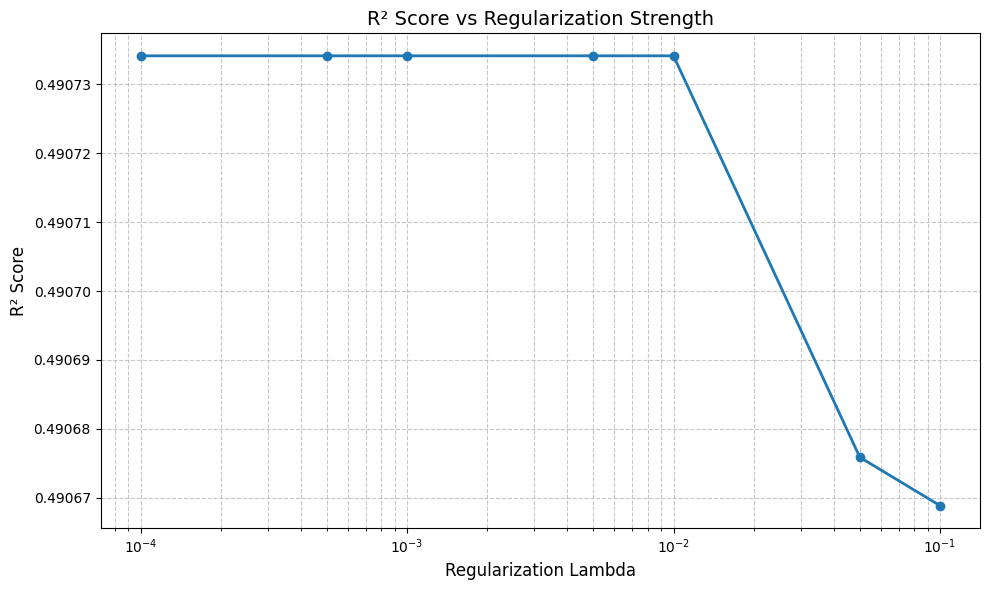

In [30]:
# Plot R² scores as a function of regularization lambda
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(reg_lambdas, r2_scores, marker='o', linestyle='-', linewidth=2)
plt.xscale('log')  # Use log scale for x-axis since lambdas span multiple orders of magnitude
plt.xlabel('Regularization Lambda', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('R² Score vs Regularization Strength', fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()
